In [12]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
print(tf.config.list_physical_devices('GPU'))
import cv2
import imghdr
data_dir = 'signatures' 
image_exts = ['jpeg','jpg', 'bmp', 'png']
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)
data = tf.keras.utils.image_dataset_from_directory('signatures')
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 2640 files belonging to 2 classes.


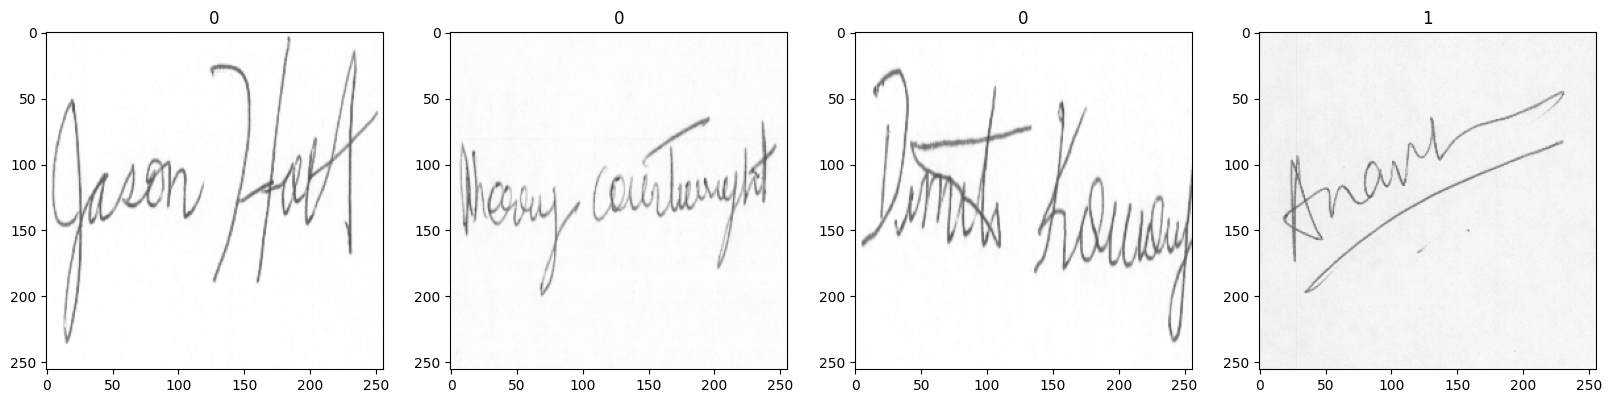

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [14]:
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)


In [15]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [16]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile('SGD', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

In [17]:
logdir='sgd'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [18]:
hist = model.fit(train, epochs=45, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/45
58/58 [==============================] - 5s 77ms/step - loss: 0.6951 - accuracy: 0.5237 - val_loss: 0.6936 - val_accuracy: 0.5059
Epoch 2/45
58/58 [==============================] - 5s 77ms/step - loss: 0.6912 - accuracy: 0.5237 - val_loss: 0.6913 - val_accuracy: 0.5059
Epoch 3/45
58/58 [==============================] - 4s 74ms/step - loss: 0.6891 - accuracy: 0.5587 - val_loss: 0.6882 - val_accuracy: 0.5234
Epoch 4/45
58/58 [==============================] - 4s 74ms/step - loss: 0.6867 - accuracy: 0.5577 - val_loss: 0.6839 - val_accuracy: 0.7285
Epoch 5/45
58/58 [==============================] - 4s 74ms/step - loss: 0.6814 - accuracy: 0.5954 - val_loss: 0.6828 - val_accuracy: 0.5312
Epoch 6/45
58/58 [==============================] - 4s 74ms/step - loss: 0.6766 - accuracy: 0.5986 - val_loss: 0.6751 - val_accuracy: 0.5273
Epoch 7/45
58/58 [==============================] - 4s 75ms/step - loss: 0.6688 - accuracy: 0.6083 - val_loss: 0.6607 - val_accuracy: 0.6973
Epoch 8/45
58

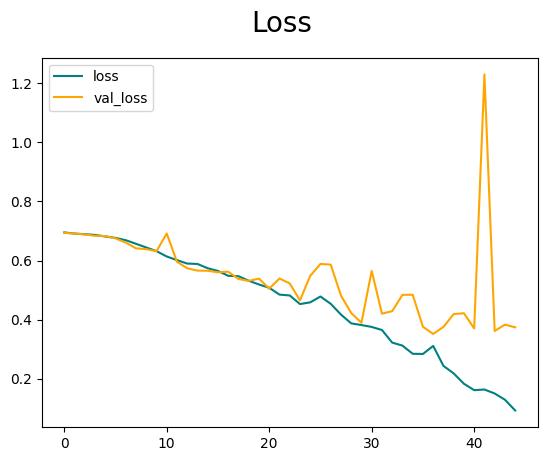

In [19]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

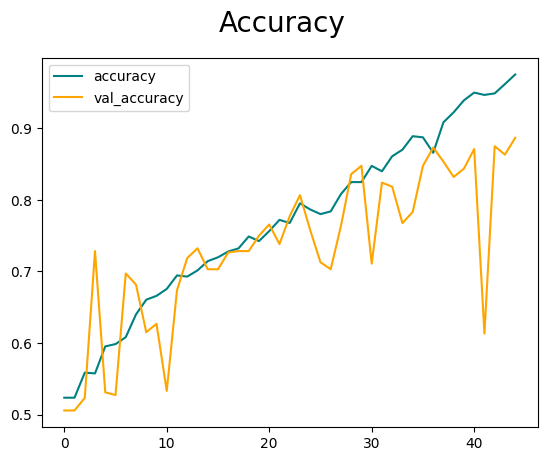

In [20]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [21]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()


In [22]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 25ms/step


In [23]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.84210527, shape=(), dtype=float32) tf.Tensor(0.91056913, shape=(), dtype=float32) tf.Tensor(0.875, shape=(), dtype=float32)


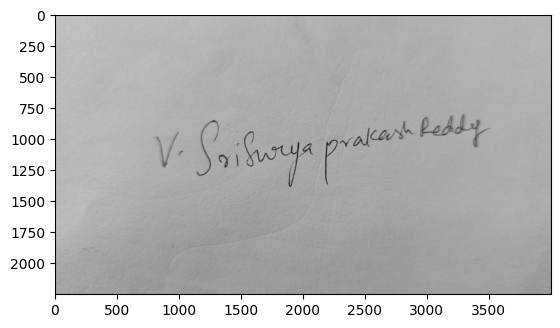

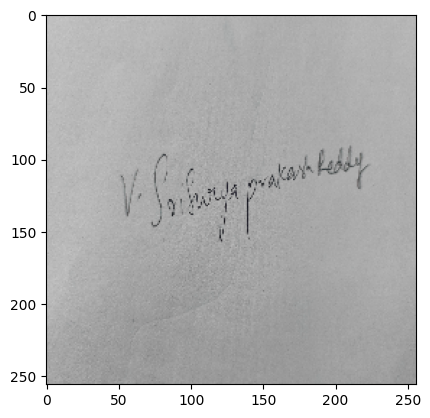

In [46]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('test1org.jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [47]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 80ms/step


In [48]:
yhat

array([[0.9053059]], dtype=float32)

In [49]:
if yhat > 0.5: 
    print(f'Predicted class is original')
else:
    print(f'Predicted class is forged')

Predicted class is original
